## Multivariate LSTM Forecast Model

In [57]:
# import related libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math 
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
# Reading File
df =  pd.read_excel('CPI_Urban.xls')

In [60]:
df = df.set_index('Date')
df = df.dropna()

In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [62]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.31178956e-03, 0.00000000e+00, 8.87167101e-02],
       [0.00000000e+00, 5.19262411e-04, 3.68649927e-04, ...,
        1.07514639e-02, 0.00000000e+00, 1.03937898e-01],
       [0.00000000e+00, 2.94389464e-03, 1.36683664e-03, ...,
        1.38152005e-02, 0.00000000e+00, 1.18357971e-01],
       ...,
       [9.82532343e-01, 9.69150692e-01, 9.66522536e-01, ...,
        4.97045362e-01, 1.00000000e+00, 9.29439743e-01],
       [9.85418303e-01, 9.18420718e-01, 9.68870117e-01, ...,
        5.04508927e-01, 1.00000000e+00, 9.49853142e-01],
       [1.00000000e+00, 8.99225593e-01, 1.00000000e+00, ...,
        5.33439387e-01, 1.00000000e+00, 7.87777515e-01]])

In [63]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [64]:
reframed.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t)
1,0.0,0.000000,0.000000,0.000000,0.003603,0.027522,0.102578,0.407773,0.298246,0.076283,...,0.035898,0.003982,0.000290,0.000073,0.557675,0.035639,0.000251,0.010751,0.0,0.103938
2,0.0,0.000519,0.000369,0.000091,0.003603,0.022119,0.079005,0.407773,0.298246,0.035898,...,0.039161,0.000000,0.000513,0.001186,0.557675,0.000000,0.000000,0.013815,0.0,0.118358
3,0.0,0.002944,0.001367,0.000165,0.003603,0.018717,0.087863,0.407773,0.298246,0.039161,...,0.043241,0.001991,0.000419,0.001347,0.557675,0.035838,0.001476,0.016846,0.0,0.095126
4,0.0,0.007682,0.001359,0.000258,0.003603,0.018994,0.029573,0.472634,0.298246,0.043241,...,0.047728,0.005973,0.000224,0.001290,0.557675,0.054988,0.002776,0.019668,0.0,0.074777
5,0.0,0.011053,0.001848,0.000369,0.003603,0.022585,0.022573,0.508494,0.298246,0.047728,...,0.043649,0.011946,0.001769,0.000965,0.557675,0.021924,0.002956,0.022323,0.0,0.076540


In [65]:
reframed.dtypes

var1(t-1)     float64
var2(t-1)     float64
var3(t-1)     float64
var4(t-1)     float64
var5(t-1)     float64
var6(t-1)     float64
var7(t-1)     float64
var8(t-1)     float64
var9(t-1)     float64
var10(t-1)    float64
var11(t-1)    float64
var12(t-1)    float64
var13(t-1)    float64
var14(t-1)    float64
var15(t-1)    float64
var16(t-1)    float64
var17(t-1)    float64
var18(t-1)    float64
var19(t-1)    float64
var1(t)       float64
var2(t)       float64
var3(t)       float64
var4(t)       float64
var5(t)       float64
var6(t)       float64
var7(t)       float64
var8(t)       float64
var9(t)       float64
var10(t)      float64
var11(t)      float64
var12(t)      float64
var13(t)      float64
var14(t)      float64
var15(t)      float64
var16(t)      float64
var17(t)      float64
var18(t)      float64
var19(t)      float64
dtype: object

In [66]:
a = range(20,38,1)
reframed.drop(reframed.columns[a], axis=1, inplace=True)
reframed.dtypes

var1(t-1)     float64
var2(t-1)     float64
var3(t-1)     float64
var4(t-1)     float64
var5(t-1)     float64
var6(t-1)     float64
var7(t-1)     float64
var8(t-1)     float64
var9(t-1)     float64
var10(t-1)    float64
var11(t-1)    float64
var12(t-1)    float64
var13(t-1)    float64
var14(t-1)    float64
var15(t-1)    float64
var16(t-1)    float64
var17(t-1)    float64
var18(t-1)    float64
var19(t-1)    float64
var1(t)       float64
dtype: object

In [73]:
values = reframed.values
train = values[:-12, :]
test = values[-12:]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(351, 1, 19) (351,) (12, 1, 19) (12,)


Train on 351 samples, validate on 12 samples
Epoch 1/50
 - 1s - loss: 0.3129 - val_loss: 0.8686
Epoch 2/50
 - 0s - loss: 0.2290 - val_loss: 0.7250
Epoch 3/50
 - 0s - loss: 0.1625 - val_loss: 0.5863
Epoch 4/50
 - 0s - loss: 0.1206 - val_loss: 0.4601
Epoch 5/50
 - 0s - loss: 0.1020 - val_loss: 0.3509
Epoch 6/50
 - 0s - loss: 0.0889 - val_loss: 0.2620
Epoch 7/50
 - 0s - loss: 0.0815 - val_loss: 0.1950
Epoch 8/50
 - 0s - loss: 0.0715 - val_loss: 0.1459
Epoch 9/50
 - 0s - loss: 0.0594 - val_loss: 0.1146
Epoch 10/50
 - 0s - loss: 0.0450 - val_loss: 0.1055
Epoch 11/50
 - 0s - loss: 0.0343 - val_loss: 0.0906
Epoch 12/50
 - 0s - loss: 0.0302 - val_loss: 0.0556
Epoch 13/50
 - 0s - loss: 0.0301 - val_loss: 0.0291
Epoch 14/50
 - 0s - loss: 0.0286 - val_loss: 0.0257
Epoch 15/50
 - 0s - loss: 0.0254 - val_loss: 0.0333
Epoch 16/50
 - 0s - loss: 0.0235 - val_loss: 0.0339
Epoch 17/50
 - 0s - loss: 0.0215 - val_loss: 0.0235
Epoch 18/50
 - 0s - loss: 0.0202 - val_loss: 0.0177
Epoch 19/50
 - 0s - loss: 0.

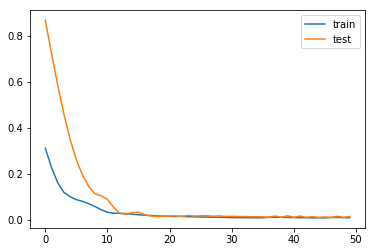

In [68]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [69]:
#make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.352


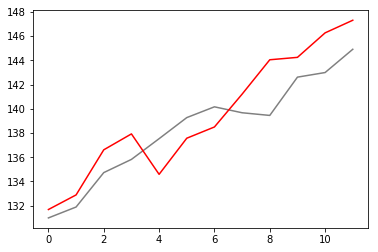

In [70]:
#Ploting Fitted and Actual values
plt.plot(inv_y,color="gray")
plt.plot(inv_yhat,color="red")
plt.show()